Imports and constants

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from pathlib import Path
from tqdm import tqdm

import torch
import torch.utils.data as thd
import torch.nn as nn

from sklearn.metrics import fbeta_score, precision_score, recall_score

from scipy.ndimage.filters import gaussian_filter1d

import matplotlib.pyplot as plt

from collections import defaultdict
import os

import gc

BATCH_SIZE = 256
BUFFER = 10  # Buffer size in both dimensions: x and y. Effective patch size is [BUFFER * 2 + 1, BUFFER * 2 + 1, Z_DIM].
SLICES = 65
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.005
Z_START = 25
Z_END = 45
Z_STEP = 2
Z_DIM = (Z_END - Z_START) // Z_STEP

MAX_TRAIN_STEPS = 55000
MAX_VAL_STEPS = 1000
PRINT_EVERY = 20000000

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, let's see if we can fit all one full fragment into memory at once.

In [2]:
def pad_array(array):
    padding = (
        (BUFFER, BUFFER),
        (BUFFER, BUFFER),
    )
    return np.pad(array, padding)

def load_fragment_surface(fragment, split='train'):
    print("Loading fragment %s surface" % fragment)
    surface_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/surface_volume" % (split, fragment))
    return np.array([
        (pad_array(np.array(Image.open(f))) / (2 ** 16)).astype('float16')
        for f in tqdm(sorted(surface_path.rglob("*.tif"))[Z_START:Z_END:Z_STEP])
    ])

def load_mask(fragment, split='train'):
    print("Loading fragment %s mask" % fragment)
    mask_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/mask.png" % (split, fragment))
    return pad_array(np.array(Image.open(mask_path)))

def load_inklabels(fragment, split='train'):
    print("Loading fragment %s labels" % fragment)
    inklabels_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/inklabels.png" % (split, fragment))
    return pad_array(np.array(Image.open(inklabels_path)))

In [3]:
class SingleFragmentDataset(thd.Dataset):
    def __init__(self, fragment, is_test=False):
        self.is_test = is_test
        split = 'test' if is_test else 'train'
        self.surface = load_fragment_surface(fragment, split)
        print(self.surface.dtype)
        self.mask = load_mask(fragment, split)
        self.inklabels = load_inklabels(fragment, split) if not is_test else None
        self.pixels = np.stack(np.where(self.mask == 1), axis=1)
    
    def __len__(self):
        return self.pixels.shape[0]
    
    def get_pixel_number(self, y, x):
        return 1 + y * self.surface.shape[1] + x
    
    def __getitem__(self, index):
        y, x = self.pixels[index]
        y_start = y - BUFFER
        y_end = y + BUFFER + 1
        x_start = x - BUFFER
        x_end = x + BUFFER + 1
        patch_surface = np.s_[:, y_start:y_end, x_start:x_end]
        patch_labels = np.s_[y_start:y_end, x_start:x_end]
        surface = self.surface[patch_surface].astype(np.float32)
        labels = self.inklabels[y, x].reshape((1, )).astype(np.float32) if not self.is_test else None
        return (surface, labels) if not self.is_test else (surface, self.get_pixel_number(y, x))

In [4]:
%%time
train_dataset = SingleFragmentDataset(1)
print(train_dataset.surface.shape)

Loading fragment 1 surface


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


float16
Loading fragment 1 mask
Loading fragment 1 labels
(10, 8201, 6350)
CPU times: user 4.64 s, sys: 3.38 s, total: 8.03 s
Wall time: 21 s


In [5]:
# plt.hist(train_dataset.surface.flatten())

In [6]:
from operator import itemgetter

from pympler import tracker

print(gc.collect())

mem = tracker.SummaryTracker()
print(sorted(mem.create_summary(), reverse=True, key=itemgetter(2))[:10])

0


/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


[['str', 309818, 50229198], ['dict', 103890, 34134448], ['code', 80892, 14400814], ['type', 11080, 10498888], ['list', 64045, 6449776], ['tuple', 93302, 5948440], ['set', 3614, 2341968], ['collections.OrderedDict', 2678, 1646248], ['weakref.ReferenceType', 18387, 1323864], ['builtin_function_or_method', 15922, 1146384]]


In [7]:
train_loader = thd.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

Define the model

In [8]:
convnet = nn.Sequential(
    nn.Conv2d(Z_DIM, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 16, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 8, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 1, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear((2 * BUFFER + 1) ** 2, 128),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(DEVICE)

Train the model

In [9]:
%%time
losses = []
accs = []
fbetas = []

convnet.train()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(convnet.parameters(), lr=LEARNING_RATE)
for i, (xs, ys) in enumerate(pbar := tqdm(train_loader)):
    if i > MAX_TRAIN_STEPS:
        break
    optimizer.zero_grad()
    outputs = convnet(xs.to(DEVICE))
    if i % PRINT_EVERY == PRINT_EVERY - 1:
        print(outputs)
        plt.plot(gaussian_filter1d(losses, sigma=10), label='loss')
        plt.plot(gaussian_filter1d(accs, sigma=10), label='accs')
        plt.plot(gaussian_filter1d(fbetas, sigma=10), label='fbetas')
        plt.legend()
    loss = criterion(outputs, ys.to(DEVICE))
    pred_ink = outputs.detach().gt(0.4).cpu().int()
    accuracy = (pred_ink == ys).sum().float().div(ys.size(0))
    fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
    pbar.set_postfix({"loss": loss, "acc": accuracy, "fbeta": fbeta})
    loss.backward()
    optimizer.step()
    
    fbetas.append(fbeta)
    losses.append(loss.detach().cpu().float())
    accs.append(accuracy)

 48%|████▊     | 55001/113840 [28:38<30:38, 32.00it/s, loss=tensor(0.3766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8281), fbeta=0.297]

CPU times: user 28min 9s, sys: 24.6 s, total: 28min 34s
Wall time: 28min 38s


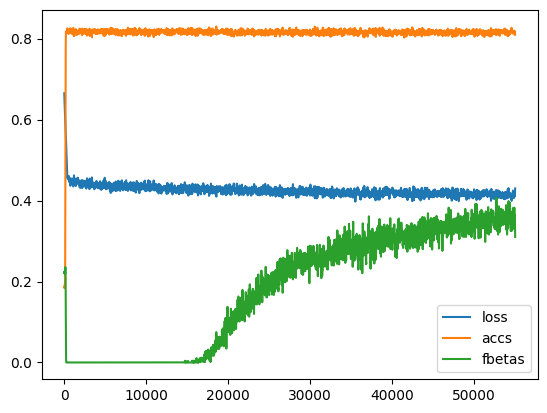

In [10]:
plt.plot(gaussian_filter1d(losses, sigma=10), label='loss')
plt.plot(gaussian_filter1d(accs, sigma=10), label='accs')
plt.plot(gaussian_filter1d(fbetas, sigma=10), label='fbetas')
plt.legend()

Validate the model

Loading fragment 3 surface


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


float16
Loading fragment 3 mask
Loading fragment 3 labels
Evaluating for threshold 0.100000


  1%|          | 1001/97913 [00:29<47:50, 33.76it/s, loss=tensor(0.6364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8359), fbeta=0.0649]


Evaluating for threshold 0.200000


  0%|          | 95/97913 [00:05<41:29, 39.30it/s, loss=tensor(0.4689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8906), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 121/97913 [00:06<41:41, 39.09it/s, loss=tensor(0.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8594), fbeta=0.172] /opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 278/97913 [00:10<41:37, 39.10it/s, loss=tensor(0.5804, device='cuda:0', grad_fn=<Bi

Evaluating for threshold 0.300000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 5/97913 [00:03<14:35:21,  1.86it/s, loss=tensor(0.6583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8750), fbeta=0.109]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 5/97913 [00:03<14:35:21,  1.86it/s, loss=tensor(0.6890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8477), fbeta=0]    /opt/conda/lib/python3.10/site-packages/sklearn/metri

Evaluating for threshold 0.400000


  0%|          | 1/97913 [00:03<82:20:47,  3.03s/it, loss=tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8828), fbeta=0.132]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<82:20:47,  3.03s/it, loss=tensor(0.6536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8633), fbeta=0]    /opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<82:20:47,  3.03s/it, loss=tensor(0.3914, device='cuda:0', grad

Evaluating for threshold 0.500000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<83:05:57,  3.06s/it, loss=tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8711), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<83:05:57,  3.06s/it, loss=tensor(0.6683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8633), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_clas

Evaluating for threshold 0.600000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:02<81:03:55,  2.98s/it, loss=tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8789), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<81:03:55,  2.98s/it, loss=tensor(0.5654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8711), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_clas

Evaluating for threshold 0.700000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:04<113:41:24,  4.18s/it, loss=tensor(0.4272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.9023), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:04<113:41:24,  4.18s/it, loss=tensor(0.6206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8633), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_cl

Evaluating for threshold 0.800000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:02<81:26:14,  2.99s/it, loss=tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8789), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<81:26:14,  2.99s/it, loss=tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8789), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_clas

Evaluating for threshold 0.900000


  0%|          | 0/97913 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<81:37:06,  3.00s/it, loss=tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8789), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/97913 [00:03<81:37:06,  3.00s/it, loss=tensor(0.5791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>), acc=tensor(0.8789), fbeta=0]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_clas

Best threshold: 0.1


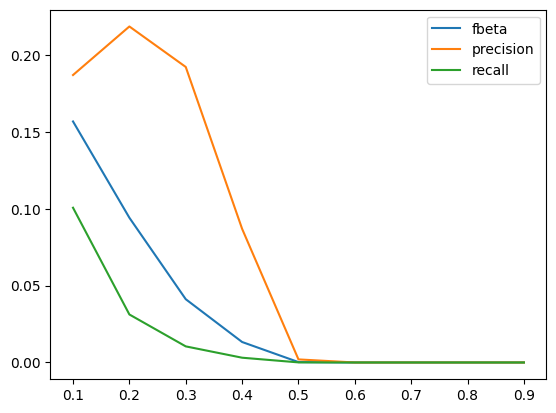

In [11]:
del train_loader
del train_dataset
gc.collect()

convnet.eval()
val_dataset = SingleFragmentDataset(3)
val_loader = thd.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

def evaluate(convnet, val_loader, threshold):
    print("Evaluating for threshold %f" % threshold)
    losses = []
    accs = []
    fbetas = []
    precisions = []
    recalls = []

    for i, (xs, ys) in enumerate(pbar := tqdm(val_loader)):
        if i > MAX_VAL_STEPS:
            break
        outputs = convnet(xs.to(DEVICE))
        loss = criterion(outputs, ys.to(DEVICE))
        pred_ink = outputs.detach().gt(threshold).cpu().int()
        accuracy = (pred_ink == ys).sum().float().div(ys.size(0))
        fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        pbar.set_postfix({"loss": loss, "acc": accuracy, "fbeta": fbeta})

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(losses), np.mean(accs), np.mean(fbetas), np.mean(precisions), np.mean(recalls)


def evaluate_for_thresholds():
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    best_fbeta = 0.
    best_threshold = 0
    
    fbetas = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        _, _, fbeta, precision, recall = evaluate(convnet, val_loader, threshold)
        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_threshold = threshold
        fbetas.append(fbeta)
        precisions.append(precision)
        recalls.append(recall)
    
    plt.plot(thresholds, fbetas, label="fbeta")
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.legend()
    
    return best_threshold

best_threshold = evaluate_for_thresholds()
print("Best threshold:", best_threshold)

Generate test predictions

In [12]:
del val_loader
del val_dataset
gc.collect()

submission = defaultdict(list)

for fragment in ['a', 'b']:
    pixels_with_ink = []
    print(f"Generating predictions for fragment {fragment}")
    test_dataset = SingleFragmentDataset(fragment, is_test=True)
    test_loader = thd.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
    for (xs, ys) in (pbar := tqdm(test_loader)):
        output = convnet(xs.to(DEVICE))
        pred_ink = outputs.detach().gt(best_threshold).flatten().cpu().int()
        pred_ink = pred_ink[:len(ys)]
        pixels_with_ink += ys[pred_ink == 1].int().tolist()
    pixels_with_ink.sort()
    
    submission["Id"].append(fragment)
    submission["Predicted"].append(' '.join(list(map(lambda p: "%s 1" % p, pixels_with_ink))))
    
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

Generating predictions for fragment a
Loading fragment a surface


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


float16
Loading fragment a mask


100%|██████████| 42262/42262 [11:45<00:00, 59.87it/s]


Generating predictions for fragment b
Loading fragment b surface


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


float16
Loading fragment b mask


100%|██████████| 71578/71578 [20:04<00:00, 59.41it/s]


In [13]:
pd.DataFrame.from_dict(submission)

,Id,Predicted
0,a,35417 1 35419 1 38163 1 38164 1 38166 1 38168 ...
1,b,55848 1 55849 1 55850 1 55852 1 55853 1 55854 ...
